In [2]:
# imports necesarios
import numpy as np
import matplotlib.pyplot as plt
import os
import torch 

# parametros fisicos en mm para evitar inestabilidad numerica
ALPHA = 97.4  # difusividad termica del aluminio (mm^2/s)
L_SIZE = 50.0  # dimension del dominio cuadrado (mm)
H_BASE = 10.0  # altura de la base solida del disipador (mm)
T_MAX = 500.0  # tiempo total de simulacion (s)
TEMP_BASE = 80.0  # temperatura de la base caliente (°C)
TEMP_AMB = 20.0  # temperatura ambiente (°C)

# cantidad de puntos de entrenamiento
N_DOMAIN = 70000  # puntos interiores para la ecuacion de calor
N_BOUNDARY = 20000  # puntos de frontera con condiciones conocidas
N_INITIAL = 10000  # puntos en t=0 con temperatura inicial


In [3]:
# definicion de la geometria del disipador
# el disipador tiene una base solida (0 a 10mm en y) y 4 aletas verticales
# esta geometria maximiza el area de contacto con el aire para disipar calor
# el calor entra por la base (y=0) y se dispersa por las aletas
# las aletas aumentan el area superficial sin agregar mucho peso
# los huecos entre aletas permiten el flujo de aire (conveccion natural)
def is_inside_heatsink(x, y):
    """
    retorna true si el punto (x,y) esta dentro del material solido del disipador
    geometria: base solida + 4 aletas de 5mm separadas por 10mm
    """
    
    # base solida: toda la region debajo de H_BASE contiene material
    in_base = y <= H_BASE
    
    # aletas verticales con posiciones exactas en mm:
    # aleta 1: x en [0, 5]
    # hueco 1: x en [5, 15]
    # aleta 2: x en [15, 20]
    # hueco 2: x en [20, 30]
    # aleta 3: x en [30, 35]
    # hueco 3: x en [35, 45]
    # aleta 4: x en [45, 50]
    f1 = (x >= 0.0) & (x <= 5.0)
    f2 = (x >= 15.0) & (x <= 20.0)
    f3 = (x >= 30.0) & (x <= 35.0)
    f4 = (x >= 45.0) & (x <= 50.0)
    
    # las aletas solo existen arriba de la base
    in_fins = (y > H_BASE) & (y <= L_SIZE) & (f1 | f2 | f3 | f4)
    
    # union de base y aletas dentro de los limites del dominio
    return (in_base | in_fins) & (x >= 0) & (x <= L_SIZE) & (y >= 0) & (y <= L_SIZE)


In [4]:
# generacion de puntos interiores para la ecuacion de calor
print("Generando Puntos de Colocación (Interior)...")
domain_list = []
while len(domain_list) < N_DOMAIN:
    batch_size = N_DOMAIN * 2
    x_cand = np.random.uniform(0, L_SIZE, size=batch_size)
    y_cand = np.random.uniform(0, L_SIZE, size=batch_size)
    t_cand = np.random.uniform(0, T_MAX, size=batch_size)
    
    # filtrar solo puntos dentro del material
    mask = is_inside_heatsink(x_cand, y_cand)
    
    if np.sum(mask) > 0:
        pts = np.stack([x_cand[mask], y_cand[mask], t_cand[mask]], axis=1)
        domain_list.append(pts)
        current_len = sum(len(p) for p in domain_list)
        if current_len >= N_DOMAIN:
            break

X_domain = np.concatenate(domain_list, axis=0)[:N_DOMAIN]
print(f"Puntos de Dominio generados: {X_domain.shape}")


Generando Puntos de Colocación (Interior)...
Puntos de Dominio generados: (70000, 3)


In [5]:
# generacion de puntos de frontera con condiciones conocidas
# la base (y=0) esta en contacto con un componente a 80°C (fuente de calor)
# las superficies externas de las aletas estan expuestas al aire a 20°C (disipacion)
# estas son condiciones de dirichlet: temperatura fija en los bordes
print("Generando Puntos de Frontera (Walls)...")
boundary_pts = []
boundary_vals = []

def add_wall(x0, x1, y0, y1, temp, count):
    x = np.random.uniform(x0, x1, count) if x0 != x1 else np.full(count, x0)
    y = np.random.uniform(y0, y1, count) if y0 != y1 else np.full(count, y0)
    t = np.random.uniform(0, T_MAX, count)
    return np.stack([x, y, t], axis=1), np.full((count, 1), temp)

n_wall = N_BOUNDARY // 5 

# base caliente: fuente de calor a 80°C
pts, val = add_wall(0, L_SIZE, 0, 0, TEMP_BASE, n_wall * 4) 
boundary_pts.append(pts); boundary_vals.append(val)

# superficies externas de las aletas: disipacion al aire a 20°C
# detectamos bordes perturbando puntos y viendo si salen del material
tries = 0
while len(np.concatenate(boundary_pts)) < N_BOUNDARY:
    x = np.random.uniform(0, L_SIZE, 10000)
    y = np.random.uniform(0, L_SIZE, 10000)
    t = np.random.uniform(0, T_MAX, 10000)
    
    # deteccion de bordes: un punto esta en el borde si esta dentro
    # pero al menos un vecino inmediato esta fuera
    epsilon = 0.5
    in_now = is_inside_heatsink(x, y)
    in_up  = is_inside_heatsink(x, y + epsilon)
    in_right = is_inside_heatsink(x + epsilon, y)
    in_left = is_inside_heatsink(x - epsilon, y)
    
    is_edge = in_now & (~in_up | ~in_right | ~in_left) 
    
    # excluir la base para no duplicar
    is_edge = is_edge & (y > 0.1) 
    
    if np.sum(is_edge) > 0:
        pts = np.stack([x[is_edge], y[is_edge], t[is_edge]], axis=1)
        vals = np.full((np.sum(is_edge), 1), TEMP_AMB)
        boundary_pts.append(pts)
        boundary_vals.append(vals)
        
    if len(np.concatenate(boundary_pts)) > N_BOUNDARY * 0.9: 
        break

X_boundary = np.concatenate(boundary_pts, axis=0)[:N_BOUNDARY]
T_boundary = np.concatenate(boundary_vals, axis=0)[:N_BOUNDARY]
print(f"Puntos de Frontera generados: {X_boundary.shape}")


Generando Puntos de Frontera (Walls)...
Puntos de Frontera generados: (18268, 3)


In [6]:
# condicion inicial: temperatura en t=0
# el disipador comienza frio (20°C) antes de entrar en contacto con la fuente
# al activarse la fuente, el calor se difunde desde la base hacia las aletas
print("Generando Condición Inicial (t=0) - Interior Frío...")

ic_list = []
t_list = []
EXCLUSION_ZONE = 0.1 

while len(ic_list) < N_INITIAL:
    x = np.random.uniform(0, L_SIZE, N_INITIAL * 2)
    y = np.random.uniform(EXCLUSION_ZONE, L_SIZE, N_INITIAL * 2)
    t = np.zeros(N_INITIAL * 2) 
    
    mask = is_inside_heatsink(x, y)
    
    x_valid, y_valid, t_valid = x[mask], y[mask], t[mask]
    
    pts = np.stack([x_valid, y_valid, t_valid], axis=1)
    temp_vals = np.full((len(pts), 1), TEMP_AMB) 
    
    ic_list.append(pts)
    t_list.append(temp_vals)
    
    if sum(len(p) for p in ic_list) >= N_INITIAL:
        break

X_initial = np.concatenate(ic_list, axis=0)[:N_INITIAL]
T_initial = np.concatenate(t_list, axis=0)[:N_INITIAL]
print(f"Puntos Iniciales generados: {X_initial.shape}")


Generando Condición Inicial (t=0) - Interior Frío...
Puntos Iniciales generados: (10000, 3)


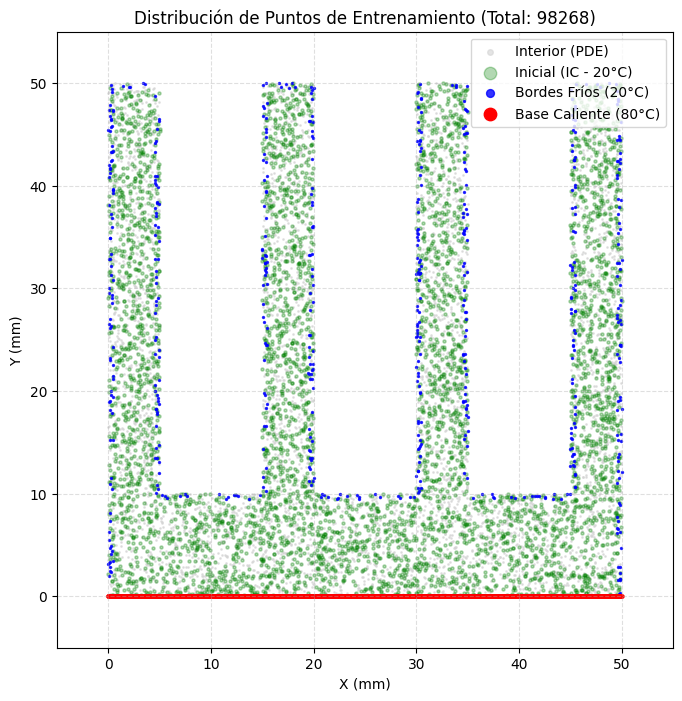

In [7]:
# visualizacion de la distribucion de puntos
N_SAMPLE = 5000 
X_d_sample = X_domain[np.random.choice(X_domain.shape[0], N_SAMPLE, replace=False), :]
X_b_sample = X_boundary[np.random.choice(X_boundary.shape[0], N_SAMPLE, replace=False), :]
X_i_sample = X_initial[np.random.choice(X_initial.shape[0], N_SAMPLE, replace=False), :]

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(X_d_sample[:, 0], X_d_sample[:, 1], s=1, color='lightgray', label='Interior (PDE)', alpha=0.6)
ax.scatter(X_i_sample[:, 0], X_i_sample[:, 1], s=5, color='green', label='Inicial (IC - 20°C)', alpha=0.3)

TOLERANCE_Y0 = 0.1 
base_mask = X_b_sample[:, 1] < TOLERANCE_Y0 
ax.scatter(X_b_sample[~base_mask, 0], X_b_sample[~base_mask, 1], s=2, color='blue', label='Bordes Fríos (20°C)', alpha=0.8)
ax.scatter(X_b_sample[base_mask, 0], X_b_sample[base_mask, 1], s=5, color='red', label='Base Caliente (80°C)', alpha=1.0)

ax.set_title(f"Distribución de Puntos de Entrenamiento (Total: {X_domain.shape[0] + X_boundary.shape[0] + X_initial.shape[0]})")
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_xlim(-5, L_SIZE + 5)
ax.set_ylim(-5, L_SIZE + 5)
ax.set_aspect('equal')
ax.legend(markerscale=4)
ax.grid(True, linestyle='--', alpha=0.4)
plt.show()


In [8]:
# guardado de datos para entrenamiento
np.savez("heatsink_data.npz", 
         X_domain=X_domain, 
         X_boundary=X_boundary, T_boundary=T_boundary,
         X_initial=X_initial, T_initial=T_initial,
         params=np.array([ALPHA, L_SIZE, T_MAX, TEMP_AMB, TEMP_BASE]))

print("Archivo 'heatsink_data.npz' guardado.")


Archivo 'heatsink_data.npz' guardado.
